In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import datasets, models, transforms

import os
import shutil

%matplotlib inline

In [0]:
seed = 128
rng = np.random.RandomState(seed)

In [0]:
# check if CUDA GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is NOT available. Training on CPU...")
else:
  print("CUDA is available! Training on GPU...")

CUDA is available! Training on GPU...


# Download, Split and Transform our Data

After downloading the data, split the training data into a training and validation set. Then create DataLoaders for each of these sets of data.

In [0]:
os.environ['KAGGLE_USERNAME'] = "###" # username from the json file
os.environ['KAGGLE_KEY'] = "###" # key from the json file
!kaggle datasets download -d ma7555/cat-breeds-dataset


 99% 1.91G/1.93G [00:22<00:00, 93.3MB/s]
100% 1.93G/1.93G [00:22<00:00, 91.9MB/s]


In [0]:
import zipfile

local_zip = '/content/cat-breeds-dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/cats')
zip_ref.close()

In [0]:
home_dir = os.getcwd()

In [0]:
# get the number of breeds saved as folders in the image dataset
num_breed_folders = len(os.listdir(os.path.join(home_dir, 'cats/images')))
num_breed_folders

67

In [0]:
# inspect CSV data
cats_df = pd.read_csv(os.path.join(home_dir, 'cats/data/cats.csv'))
# remove 'Unnamed: 0' column
cats_df.drop(['Unnamed: 0'], axis=1, inplace=True)
cats_df.head()

,id,url,type,age,gender,size,coat,breed,photos,med_photos
0,46744842,https://www.petfinder.com/cat/arianna-46744842...,Cat,Adult,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
1,46717321,https://www.petfinder.com/cat/ozzy-46717321/oh...,Cat,Adult,Male,Extra Large,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
2,46626338,https://www.petfinder.com/cat/zena-46626338/ca...,Cat,Senior,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
3,46620170,https://www.petfinder.com/cat/mika-46620170/ca...,Cat,Baby,Female,Small,Short,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
4,46582751,https://www.petfinder.com/cat/ruby-46582751/fl...,Cat,Young,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...


In [0]:
# get the total number of image files
num_images = sum(len(f) for r, d, f in os.walk(os.path.join(home_dir, 'cats/images')))
num_images

126607

In [0]:
# check the total number of images 
for r, d, f in os.walk(os.path.join(home_dir, 'cats/images')):
  print(f'{r}', len(f))

/content/cats/images 0
/content/cats/images/Sphynx - Hairless Cat 209
/content/cats/images/Tiger 2256
/content/cats/images/Dilute Tortoiseshell 3152
/content/cats/images/Silver 94
/content/cats/images/Chausie 24
/content/cats/images/Somali 36
/content/cats/images/Canadian Hairless 4
/content/cats/images/Norwegian Forest Cat 580
/content/cats/images/Selkirk Rex 77
/content/cats/images/American Curl 149
/content/cats/images/Applehead Siamese 135
/content/cats/images/Javanese 25
/content/cats/images/Chartreux 84
/content/cats/images/Balinese 254
/content/cats/images/LaPerm 17
/content/cats/images/Himalayan 1301
/content/cats/images/Scottish Fold 380
/content/cats/images/Singapura 22
/content/cats/images/Snowshoe 1625
/content/cats/images/Oriental Tabby 101
/content/cats/images/Ragdoll 2669
/content/cats/images/Tuxedo 3181
/content/cats/images/Cymric 17
/content/cats/images/Siberian 189
/content/cats/images/Manx 2059
/content/cats/images/Turkish Angora 750
/content/cats/images/Turkish Van 

## Split into Train and Test sets

In [0]:
if os.path.exists(os.path.join(home_dir, 'cats_data')):
  shutil.rmtree(os.path.join(home_dir, 'cats_data'))

# make directories for train and test
root_dir = os.path.join(home_dir, 'cats_data')
os.makedirs(root_dir)

# make train and test dirs
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

os.makedirs(train_dir)
os.makedirs(test_dir)

# make folders representing each breed in each train and test dir
for label in cats_df['breed'].unique():
  os.makedirs(os.path.join(train_dir, label))
  os.makedirs(os.path.join(test_dir, label))

In [0]:
for i, (r, d, f) in enumerate(os.walk(os.path.join(home_dir, 'cats/images'))):
  print(r, f)
  if i == 5:
    break

/content/cats/images []
/content/cats/images/Sphynx - Hairless Cat ['35382968_115.jpg', '41166063_65.jpg', '30442925_185.jpg', '38589548_85.jpg', '25949037_223.jpg', '18332395_299.jpg', '37768883_95.jpg', '44154257_26.jpg', '24657373_237.jpg', '31736281_171.jpg', '32674679_156.jpg', '20193474_273.jpg', '35965177_109.jpg', '20044566_278.jpg', '20193489_272.jpg', '34410063_124.jpg', '39013001_78.jpg', '44504562_22.jpg', '42540142_52.jpg', '42014207_55.jpg', '18610319_296.jpg', '26327808_216.jpg', '41980654_57.jpg', '24661358_236.jpg', '35585753_112.jpg', '26726596_209.jpg', '19808435_286.jpg', '33227074_146.jpg', '18332348_298.jpg', '43003417_42.jpg', '26833178_207.jpg', '42588797_53.jpg', '39103128_76.jpg', '22992252_251.jpg', '43102068_37.jpg', '39871977_72.jpg', '33242958_142.jpg', '32750890_155.jpg', '24741780_234.jpg', '23166056_249.jpg', '43231715_34.jpg', '41494396_63.jpg', '25397312_227.jpg', '20044586_276.jpg', '38024287_90.jpg', '33187075_148.jpg', '30591905_183.jpg', '45219485

In [0]:
sparse_breeds_list = []

for i, (r, d, f) in enumerate(os.walk(os.path.join(home_dir, 'cats/images'))):
  label = r.split('/')[-1]

  if i == 0:
    continue

  filenames = f
  # shuffle filenames
  np.random.shuffle(filenames)
  # split files in current folder into train and test sets, in 80:20 ratio
  train_file_length = int(len(filenames)*0.8)
  
  # remove sparse breeds to minimize chances of overfitting
  if train_file_length < 100:
    print(f"SKIPPING {label}")
    sparse_breeds_list.append(label)
    continue

  filenames_array = np.array(filenames)
  train_files= filenames_array[:train_file_length]
  test_files= filenames_array[train_file_length:]

  # get the full path of each image in the train and test splits
  train_filename_list = []
  test_filename_list = []
  for filename in train_files:
    train_filename_list.append(os.path.join(home_dir, f'cats/images/{label}/{filename}'))
  for filename in test_files:
    test_filename_list.append(os.path.join(home_dir, f'cats/images/{label}/{filename}'))

  # copy into data folder
  print(f"Copying {len(train_filename_list)} images into {label}'s' train folder...")
  for name in train_filename_list:
    shutil.copy(name, os.path.join(home_dir, f'cats_data/train/{label}'))

  print(f"Copying {len(test_filename_list)} images into {label}'s' test folder...")
  for name in test_filename_list:
    shutil.copy(name, os.path.join(home_dir, f'cats_data/test/{label}'))

print(f'Not training on: {sparse_breeds_list}')

Copying 167 images into Sphynx - Hairless Cat's' train folder...
Copying 42 images into Sphynx - Hairless Cat's' test folder...
Copying 1804 images into Tiger's' train folder...
Copying 452 images into Tiger's' test folder...
Copying 2521 images into Dilute Tortoiseshell's' train folder...
Copying 631 images into Dilute Tortoiseshell's' test folder...
SKIPPING Silver
SKIPPING Chausie
SKIPPING Somali
SKIPPING Canadian Hairless
Copying 464 images into Norwegian Forest Cat's' train folder...
Copying 116 images into Norwegian Forest Cat's' test folder...
SKIPPING Selkirk Rex
Copying 119 images into American Curl's' train folder...
Copying 30 images into American Curl's' test folder...
Copying 108 images into Applehead Siamese's' train folder...
Copying 27 images into Applehead Siamese's' test folder...
SKIPPING Javanese
SKIPPING Chartreux
Copying 203 images into Balinese's' train folder...
Copying 51 images into Balinese's' test folder...
SKIPPING LaPerm
Copying 1040 images into Himalayan'

In [0]:
for breed in sparse_breeds_list:
    shutil.rmtree(os.path.join(home_dir, f'cats_data/train/{breed}'))
    shutil.rmtree(os.path.join(home_dir, f'cats_data/test/{breed}'))

In [0]:
# remove original 'cats' folder once complete
# shutil.rmtree(os.path.join(home_dir, 'cats))

In [0]:
# Print totals
num_train_images = sum(len(f) for r, d, f in os.walk(os.path.join(home_dir, 'cats_data/train')))
num_test_images = sum(len(f) for r, d, f in os.walk(os.path.join(home_dir, 'cats_data/test')))

print(f"Total number of train images: {num_train_images}")
print(f"Total number of test images: {num_test_images}")

Total number of train images: 100481
Total number of test images: 25141


## Transforming the Data

When we perform transfer learning, we have to **shape our input data into the shape that the pre-trained model expects**. 

VGG16 expects **224-dim** square images as input so we resize each cat image to fit these dimensions.

We also perform **image augmentation** here to improve model accuracy: *Rotate, shear, horizontal flip, normalization*.

Next, point to the data and labels using the **ImageFolder** class, for the training and test folders.

In [0]:
# load and transform data using ImageFolder

train_dir = os.path.join(home_dir, 'cats_data/train')
test_dir = os.path.join(home_dir, 'cats_data/test')

# create data transformer to resize the images, and add the same time add image augmentations
# Rotate, shear, horizontal flip
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      #transforms.RandomAffine(degrees=10, fillcolor=100),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

# The ImageFolder class should point to the folder containing the sub-folders that represent each class
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  100481
Num test images:  25141


# Create DataLoaders and Visualize the Data

In [0]:
# for handling imbalanced classes
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight                       

weights = make_weights_for_balanced_classes(train_data.imgs, len(train_data.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 

# define dataloader parameters
batch_size=50
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                            sampler=sampler,
                                            batch_size=batch_size, 
                                            num_workers=num_workers)


test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

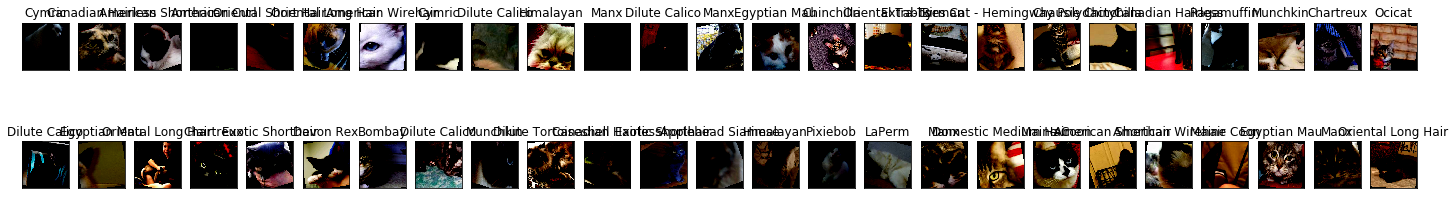

In [0]:
# Visualize some sample data

dataiter = iter(train_loader)

images, labels = dataiter.next()

classes = cats_df['breed'].unique()

images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(classes[labels[idx]])

---
## Define the Model

This is a medium-sized dataset, and not seen by the original pre-trained model. There are 2 ways to go about this:

### First method

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.** This is so as to prevent overfitting on our medium-sized dataset. 

By removing only the last layer, we assume that the pre-trained model contains high-level features that can distinguish the different cat breeds.

### Second method
We assume that the pre-trained model does not contain high-level features that are enough to distinguish between different cat breeds. Hence, we remove all but the starting layers of the model, and add and train a linear (fully-connected) layer at the end. This is so that the new network will only use layers containing the lower-level features.

We freeze the weights from the original network to avoid overfitting.

In [0]:
# load the pre-trained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

# (Method 1) Modify only the final layer, freeze the weights 
We assume that the pre-trained model's higher-level features are able to distinguish from the different cat breeds, hence we only replace the final FC layer with one that matches the number of classes we are predicting on.


In [0]:
num_classes = len([f for f in os.listdir(os.path.join(home_dir, 'cats_data/train'))])
num_classes

47

In [0]:
# check test classes too
len([f for f in os.listdir(os.path.join(home_dir, 'cats_data/test'))])

47

In [0]:
# Remove the last layer, then add one FC layer that maps n-> 47 cat breeds
import torch.nn as nn

vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
in_features = vgg16.classifier[3].out_features

last_fc_layer = nn.Linear(in_features, num_classes)

vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()), last_fc_layer)

if train_on_gpu:
  vgg16.cuda()

## Specify Loss Function and Optimizer

We will use the cross entropy loss (multiclass classification) and stochastic gradient descent with a small learning rate.

The optmizer accepts only the *trainable* parameters as input (i.e. vgg.classifier.parameters())

In [0]:
import torch.optim as optim

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [0]:
# FREEZE THE WEIGHTS
for param in vgg16.features.parameters():
  param.require_grad = False

## Training

In [0]:
# # number of epochs to train the model
# n_epochs = 1

# train_loss_min = np.Inf

# for epoch in range(1, n_epochs + 1):

#   # reset training loss to 0 for every epoch
#   train_loss = 0.0

#   for batch, (data, target) in enumerate(train_loader):
#     # move tensors to GPU if CUDA is available
#     if train_on_gpu:
#       data, target = data.cuda(), target.cuda()

#     # clear the gradients
#     optimizer.zero_grad()

#     # forward pass: compute predictions by passing input data into the model
#     output = vgg16(data)

#     # calculate batch loss
#     loss = criterion(output, target)

#     # backward pass; compute gradient of the loss wrt model parameters
#     loss.backward()

#     # perform a single optimization step (update parameters to minimize gradient loss)
#     optimizer.step()

#     # update training loss (get total loss over all the inputs)
#     train_loss += loss.item()

#     if batch % batch_size == batch_size - 1: # print training loss in every batch (batch_size) of data
#       batch_train_loss = train_loss / batch_size
#       print((f'Epoch: {epoch}, Batch {batch + 1},  Training Loss: {batch_train_loss}'))
      
#       # save model if training loss has decreased
#       if batch_train_loss <= train_loss_min:
#           print("Training loss decreased ({:.6f} --> {:.6f})".format(train_loss_min, batch_train_loss))
#           torch.save(vgg16.state_dict(), 'model_cat_breed_classifier.pt')
#           train_loss_min = batch_train_loss
      
#       # reset training loss to 0 for every batch
#       train_loss = 0

    

In [0]:
# # load the model
# vgg16.load_state_dict(torch.load(os.path.join(home_dir, 'model_cat_breed_classifier.pt')))

## Testing

In [0]:
def test_model(model):

  test_loss = 0.0
  is_class_correct = list(0. for i in range(num_classes))
  class_total = list(0. for i in range(num_classes))

  # eval code
  model.eval()

  # iterate over test data
  for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

    # forward pass
    output = model(data)

    # calculate loss
    loss = criterion(output, target)

    # update test loss
    test_loss += loss.item()*data.size(0)

    # convert outputs to predicted class;   torch.max(input, dim, keepdim=False, out=None) returns (value, index)
    _, pred = torch.max(output, 1)
    # print(f"Pred: {pred}")

    # compare predictions (a 1-D tensor) to true labels. 
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    # calculate test accuracy of each class; go through each value in the 1D tensor (20 values)
    for i in range(batch_size):
      if list(target.shape)[0] != batch_size:
        continue
      label = target.data[i]
      # count the number of times each class gets predicted correctly
      try:
        is_class_correct[label] += correct[i].item()
        # increment the number of times each class gets predicted on
        class_total[label] += 1
      except:
        continue

  # calculate avg test loss 
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

   # calculate prediction accuracy of each class, by dividing the number of times
  # the class gets predicted correctly by the number of samples in each class
  for i in range(num_classes):
    if class_total[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
          classes[i], 100 * is_class_correct[i] / class_total[i],
          np.sum(is_class_correct[i]), np.sum(class_total[i]))
      )
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nOverall Test Accuracy: %2d%% (%2d/%2d)' % (
    100. * np.sum(is_class_correct) / np.sum(class_total),
    np.sum(is_class_correct), np.sum(class_total)
  ))


In [0]:
# test_model(vgg16)

## Visualize Sample Test Results

In [0]:
def visualize(model):
  # obtain one batch of test images
  dataiter = iter(test_loader)

  images, labels = dataiter.next()
  images.numpy()

  # move model inputs to CUDA if GPU is available
  if train_on_gpu:
    images = images.cuda()

  # get sample outputs
  output = model(images)

  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                  color=("green" if preds[idx]==labels[idx].item() else "red"))

In [0]:
# visualize(vgg16)

# (Method 2) Remove final layers (CONV and FC), add and train an FC layer

The next method assumes that the higher-level features extracted from the final CNN layers in the pre-trained model are not able to distinguish between the different cat breeds.

A possible solution will be to **remove these final layers**, leaving the pre-trained model with layers that extract lower-level features in hopes that these features have sufficient ability to distinguish between the different cat breeds.

**Fully connected layers will be added** at the end to match the number of classes (breeds).

Model weights, except the final FC layer, will be **frozen** so as to prevent overfitting.

In [0]:
# load a fresh vgg16 model
vgg16_2 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16_2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# # FREEZE training for all 'features' layers
# for param in vgg16_2.features.parameters():
#   param.requires_grad = False

In [0]:
vgg16_2.features = nn.Sequential(*list(vgg16_2.features.children())[:19])
# print out the CNN layers
vgg16_2.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [0]:
# modify fc layers
vgg16_2.classifier[0].in_features = 200704    # based on slicing off at the 19th feature layer (28 * 28 * 256)
vgg16_2.classifier[0].out_features = 25088

vgg16_2.classifier[3].in_features = 25088
vgg16_2.classifier[3].out_features = 4096

vgg16_2.classifier[6].in_features = 4096
vgg16_2.classifier[6].out_features = 1000

# add relu activation, dropout layer and FC layer
vgg16_2.classifier = nn.Sequential(
    *list(vgg16_2.classifier.children()),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(1000, num_classes)
)

print(vgg16_2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
if train_on_gpu:
  vgg16_2.cuda()

## Training

In [0]:
# number of epochs to train the model
n_epochs = 3

train_loss_min = np.Inf

for epoch in range(1, n_epochs + 1):

  # reset training loss to 0 for every epoch
  train_loss = 0.0

  for batch, (data, target) in enumerate(train_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

    # clear the gradients
    optimizer.zero_grad()

    # forward pass: compute predictions by passing input data into the model
    output = vgg16(data)

    # calculate batch loss
    loss = criterion(output, target)

    # backward pass; compute gradient of the loss wrt model parameters
    loss.backward()

    # perform a single optimization step (update parameters to minimize gradient loss)
    optimizer.step()

    # update training loss (get total loss over all the inputs)
    train_loss += loss.item()

    if batch % batch_size == batch_size - 1: # print training loss in every batch (batch_size) of data
      batch_train_loss = train_loss / batch_size
      print((f'Epoch: {epoch}, Batch {batch + 1},  Training Loss: {batch_train_loss}'))

      # save model if training loss has decreased
      if batch_train_loss <= train_loss_min:
          print("Training loss decreased ({:.6f} --> {:.6f})".format(train_loss_min, batch_train_loss))
          torch.save(vgg16.state_dict(), 'model_cat_breed_classifier_2.pt')
          train_loss_min = batch_train_loss

      # reset training loss to 0 for every batch
      train_loss = 0

  

Epoch: 1, Batch 50,  Training Loss: 3.9353389739990234
Training loss decreased (inf --> 3.935339)
Epoch: 1, Batch 100,  Training Loss: 3.8885169935226442
Training loss decreased (3.935339 --> 3.888517)
Epoch: 1, Batch 150,  Training Loss: 3.8486268186569212
Training loss decreased (3.888517 --> 3.848627)
Epoch: 1, Batch 200,  Training Loss: 3.818592448234558
Training loss decreased (3.848627 --> 3.818592)
Epoch: 1, Batch 250,  Training Loss: 3.7907591104507445
Training loss decreased (3.818592 --> 3.790759)
Epoch: 1, Batch 300,  Training Loss: 3.7819132709503176
Training loss decreased (3.790759 --> 3.781913)
Epoch: 1, Batch 350,  Training Loss: 3.7427038240432737
Training loss decreased (3.781913 --> 3.742704)
Epoch: 1, Batch 400,  Training Loss: 3.7144489383697508
Training loss decreased (3.742704 --> 3.714449)
Epoch: 1, Batch 450,  Training Loss: 3.6703408193588256
Training loss decreased (3.714449 --> 3.670341)
Epoch: 1, Batch 500,  Training Loss: 3.648408041000366
Training loss de

## Testing

In [0]:
test_loss = 0.0
is_class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# eval code
vgg16_2.eval()

print(vgg16_2)

# iterate over test data
for data, target in test_loader:
  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()

  # forward pass
  # print(data.size(0), data.size(1), data.size(2), data.size(3))
  output = vgg16_2(data)

  # calculate loss
  loss = criterion(output, target)

  # update test loss
  test_loss += loss.item()*data.size(0)

  # convert outputs to predicted class;   torch.max(input, dim, keepdim=False, out=None) returns (value, index)
  _, pred = torch.max(output, 1)
  # print(f"Pred: {pred}")

  # compare predictions (a 1-D tensor) to true labels. 
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  # calculate test accuracy of each class; go through each value in the 1D tensor (20 values)
  for i in range(batch_size):
    if list(target.shape)[0] != batch_size:
      continue
    label = target.data[i]
    # count the number of times each class gets predicted correctly
    try:
      is_class_correct[label] += correct[i].item()
      # increment the number of times each class gets predicted on
      class_total[label] += 1
    except:
      continue

# calculate avg test loss 
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# calculate prediction accuracy of each class, by dividing the number of times
# the class gets predicted correctly by the number of samples in each class
for i in range(num_classes):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * is_class_correct[i] / class_total[i],
        np.sum(is_class_correct[i]), np.sum(class_total[i]))
    )
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nOverall Test Accuracy: %2d%% (%2d/%2d)' % (
  100. * np.sum(is_class_correct) / np.sum(class_total),
  np.sum(is_class_correct), np.sum(class_total)
))

## Visualize results

In [0]:
visualize(vgg16_2)